<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/soil_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import geopandas as gpd

In [4]:

# Define the generator model
def build_generator(latent_dim, sequence_length):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_dim=latent_dim),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(sequence_length, activation='linear')
    ])
    return model


In [5]:

# Define the discriminator model
def build_discriminator(sequence_length):
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_dim=sequence_length),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


In [6]:

# Define the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential([
        generator,
        discriminator
    ])
    return model


In [67]:
def validate_generator(n_lowest = 10, n_samp = 1024*8 ):
  n_lowest = 10
  result_vec = []
  noise = tf.random.normal(shape=(n_samp, latent_dim))
  synthetic_samples = generator.predict(noise)
  batch_val = next(val_gen)
  for batch_ in batch_val:
    # batch_ = batch_val[1]
    match_indices = [0,1,2,3,5,6,7,8,9]

    data = [np.mean(np.sqrt((batch_[match_indices] - samp[match_indices])**2)) for samp in synthetic_samples]

    indices = sorted(range(len(data)), key=lambda i: data[i])[:n_lowest]

    most_similar = [synthetic_samples[i] for i in indices]

    most_similar_scaled = [scaler.inverse_transform(sim.reshape(1,-1)) for sim in most_similar]

    original_scaled = [scaler.inverse_transform(sim.reshape(1,-1)) for sim in [batch_]]
    # most_similar_scaled_df = pd.DataFrame(most_similar_scaled, columns=numeric_cols.columns)

    most_similar_scaled_2d = [np.squeeze(sim) for sim in most_similar_scaled]

    original_scaled_2d = [np.squeeze(sim) for sim in original_scaled]

    most_similar_scaled_df = pd.DataFrame(most_similar_scaled_2d, columns=numeric_cols.columns)

    original_scaled_df = pd.DataFrame(original_scaled_2d, columns=numeric_cols.columns)

    result = np.sqrt((np.mean(most_similar_scaled_df['imp_c_float'])- np.mean(original_scaled_df['imp_c_float']))**2)/np.mean(original_scaled_df['imp_c_float'])
    # print(np.mean(original_scaled_df['agbd_m']))
    result_vec.append(result)
  return(result_vec)

In [66]:
# Update the training function to include validation
def train_gan(generator, discriminator, gan, epochs, batch_size, latent_dim, val_gen):
    for epoch in range(epochs):
        # Train on batches from the training generator
        for _ in range(len(train_sequences) // batch_size):
            # Generate fake sequences
            noise = tf.random.normal(shape=(batch_size, latent_dim))
            fake_sequences = generator.predict(noise)

            # Get a batch of real sequences from the training generator
            real_sequences = next(train_gen)

            # Labels for real and fake data
            real_labels = tf.ones((batch_size, 1))
            fake_labels = tf.zeros((batch_size, 1))

            # Train the discriminator
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch(real_sequences, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_sequences, fake_labels)
            d_loss = 0.5 * tf.add(d_loss_real, d_loss_fake)

            # Train the generator
            discriminator.trainable = False
            noise = tf.random.normal(shape=(batch_size, latent_dim))
            g_loss = gan.train_on_batch(noise, real_labels)

        # Validation
        val_real_sequences = next(val_gen)
        val_fake_sequences = generator.predict(tf.random.normal(shape=(batch_size, latent_dim)))
        val_d_loss_real = discriminator.evaluate(val_real_sequences, tf.ones((batch_size, 1)), verbose=0)
        val_d_loss_fake = discriminator.evaluate(val_fake_sequences, tf.zeros((batch_size, 1)), verbose=0)
        val_d_loss = 0.5 * np.add(val_d_loss_real, val_d_loss_fake)

        # Print the progress
        print(f"Epoch: {epoch+1}/{epochs}, D Loss: {d_loss}, G Loss: {g_loss}, Val D Loss: {val_d_loss}")


        if epoch % 100 == 0:
          data = validate_generator()

          # Create a histogram
          plt.hist(data, bins=10, color='blue', edgecolor='black')

          # Add labels and title
          plt.xlabel('Value')
          plt.ylabel('Frequency')
          plt.title('Simple Histogram')

          # Show the plot
          plt.show()

In [9]:
file_path = '/content/drive/My Drive/sequence_data.csv'

In [10]:
drivers_gpd = gpd.read_file('/content/drive/MyDrive/hawaii_soils/Analysis Data/250_summary_grid_dt.gpkg')

In [11]:
soils_csv = gpd.read_file('/content/drive/MyDrive/hawaii_soils/HI soils data/combined_soc_2024_04_05.csv')

In [12]:
from shapely.geometry import Point

soils_csv = soils_csv[(soils_csv['latitude'] != '') & (soils_csv['longitude'] != '')]
soils_csv['geometry'] = soils_csv.apply(lambda row: Point(float(row['longitude']), float(row['latitude'] )), axis=1)
soils_gpd = gpd.GeoDataFrame(soils_csv, geometry='geometry', crs="EPSG:4326")

In [32]:
# Ensure both GeoDataFrames have the same CRS
soils_gpd = soils_gpd.to_crs(drivers_gpd.crs)

# Perform spatial join
matched_data = gpd.sjoin_nearest(soils_gpd, drivers_gpd, how='left', distance_col='distance')

In [33]:
unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
unique_rows = unique_rows[unique_rows['distance'] < 251]
matched_data = unique_rows

In [45]:
matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]

In [51]:
len(matched_data.select_dtypes(include=[np.number]).columns)

39

In [53]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]

# Select only numeric columns
numeric_cols = matched_data.select_dtypes(include=[np.number]).iloc[:,[6,7,8,9,10,11,12,13,14,38]]

# Initialize the scaler
scaler = MinMaxScaler ()

# Fit the scaler on the numeric columns
scaler.fit(numeric_cols)

# Transform the numeric columns
scaled_numeric_cols = scaler.transform(numeric_cols)

# Convert the scaled numeric columns back to a DataFrame
scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)

# scaled_numeric_df = scaled_numeric_df
# Concatenate the ID fields back with the numeric columns
numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

In [60]:
scaled_numeric_cols[0]

10

In [61]:

# Set the dimensions and compile the models
latent_dim = 100
sequence_length = 10  # Adjust based on your sequence length

generator = build_generator(latent_dim, sequence_length)
discriminator = build_discriminator(sequence_length)
gan = build_gan(generator, discriminator)

# Compile the discriminator
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the GAN
gan.compile(optimizer='adam', loss='mse')

# # Assuming 'final_df' is your scaled dataset with numeric columns and ID fields
# # Extract only the numeric columns for the GAN
# numeric_columns = [col for col in scaled_numeric_cols.columns if scaled_numeric_cols[col].dtype in [np.float32, np.float64]]
# real_sequences_df = scaled_numeric_cols[numeric_columns]

# Convert the DataFrame to a NumPy array
real_sequences_array = scaled_numeric_cols

def real_sequence_generator(data, batch_size):
    while True:
        # Shuffle the data at the beginning of each epoch
        np.random.shuffle(data)
        for i in range(0, len(data), batch_size):
            batch = data[i:i + batch_size]
            # If the batch is smaller than the batch size, pad it with samples from the beginning
            if len(batch) < batch_size:
                padding = data[:(batch_size - len(batch))]
                batch = np.concatenate([batch, padding], axis=0)
            yield batch


# Create an instance of the generator
# real_sequence_gen = real_sequence_generator(real_sequences_array, batch_size)


In [62]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

train_sequences, val_sequences = train_test_split(real_sequences_array, test_size=0.2, random_state=42)

test_sequences, val_sequences = train_test_split(val_sequences, test_size=0.5, random_state=42)

batch_size = 128  # Set the batch size


# Define the training and validation generators
train_gen = real_sequence_generator(train_sequences, batch_size)
test_gen = real_sequence_generator(test_sequences, batch_size)
val_gen = real_sequence_generator(val_sequences, batch_size)


4/4 [==============================] - 0s 4ms/step
Epoch: 1/10000, D Loss: [0.71962816 0.01171875], G Loss: 0.2262926697731018, Val D Loss: [0.72275186 0.01953125]
256/256 [==============================] - 1s 3ms/step


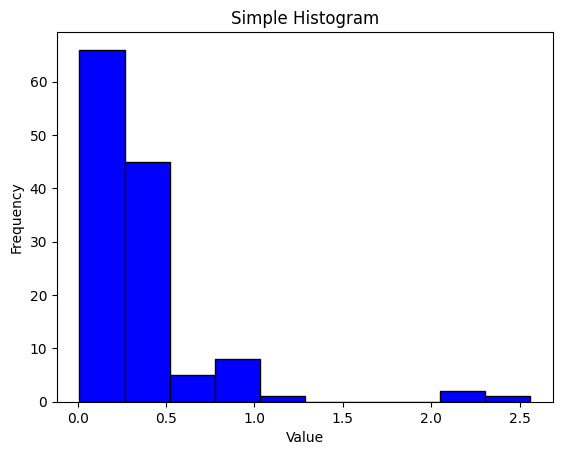

4/4 [==============================] - 0s 4ms/step
Epoch: 2/10000, D Loss: [0.7288368 0.015625 ], G Loss: 0.20240071415901184, Val D Loss: [0.73320037 0.00390625]
4/4 [==============================] - 0s 4ms/step
Epoch: 3/10000, D Loss: [0.7442665  0.00390625], G Loss: 0.17134803533554077, Val D Loss: [0.74409983 0.00390625]
4/4 [==============================] - 0s 4ms/step
Epoch: 4/10000, D Loss: [0.7521142 0.       ], G Loss: 0.13785046339035034, Val D Loss: [0.7588453 0.       ]
4/4 [==============================] - 0s 4ms/step
Epoch: 5/10000, D Loss: [0.7832153  0.00390625], G Loss: 0.10907645523548126, Val D Loss: [0.78148177 0.        ]
4/4 [==============================] - 0s 6ms/step
Epoch: 6/10000, D Loss: [0.7980351 0.       ], G Loss: 0.09010578691959381, Val D Loss: [0.8122555 0.       ]
4/4 [==============================] - 0s 7ms/step
Epoch: 7/10000, D Loss: [0.8134182 0.       ], G Loss: 0.07257606834173203, Val D Loss: [0.82470408 0.        ]
4/4 [=================

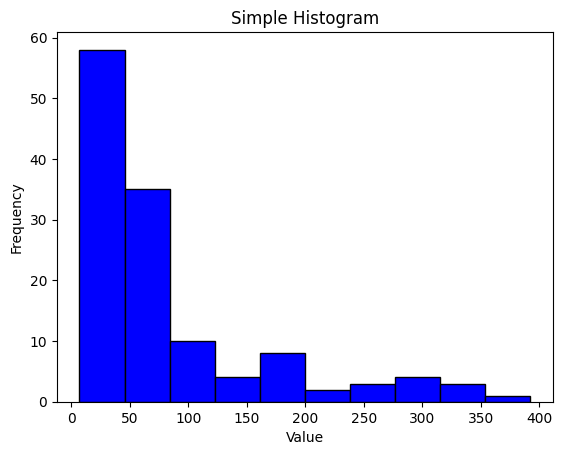

4/4 [==============================] - 0s 4ms/step
Epoch: 102/10000, D Loss: [2.497916 0.      ], G Loss: 0.0003210129216313362, Val D Loss: [2.47429714 0.        ]
4/4 [==============================] - 0s 4ms/step
Epoch: 103/10000, D Loss: [2.495319 0.      ], G Loss: 0.0002334652526769787, Val D Loss: [2.50994205 0.        ]
4/4 [==============================] - 0s 4ms/step
Epoch: 104/10000, D Loss: [2.5056357 0.       ], G Loss: 0.0002191049134125933, Val D Loss: [2.51043436 0.        ]
4/4 [==============================] - 0s 5ms/step
Epoch: 105/10000, D Loss: [2.518302 0.      ], G Loss: 0.00021389979519881308, Val D Loss: [2.5056375 0.       ]
4/4 [==============================] - 0s 4ms/step
Epoch: 106/10000, D Loss: [2.5151856 0.       ], G Loss: 0.0002003998524742201, Val D Loss: [2.51487598 0.        ]
4/4 [==============================] - 0s 5ms/step
Epoch: 107/10000, D Loss: [2.4955745 0.       ], G Loss: 0.0001765675697242841, Val D Loss: [2.51321912 0.        ]
4/4 [

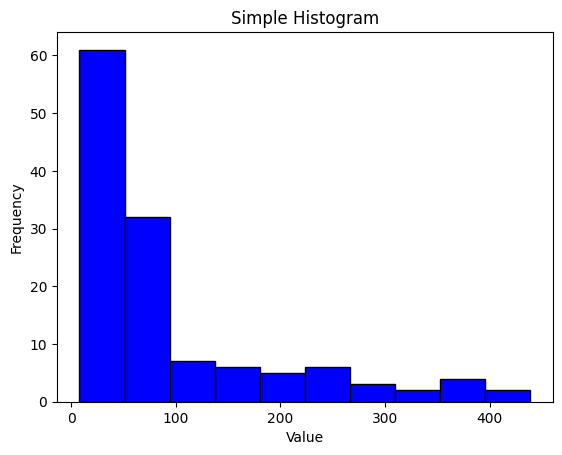

4/4 [==============================] - 0s 5ms/step
Epoch: 202/10000, D Loss: [2.8154795 0.       ], G Loss: 6.510099046863616e-05, Val D Loss: [2.80942348 0.        ]
4/4 [==============================] - 0s 5ms/step
Epoch: 203/10000, D Loss: [2.8334181 0.       ], G Loss: 6.418007251340896e-05, Val D Loss: [2.80232519 0.        ]
4/4 [==============================] - 0s 5ms/step
Epoch: 204/10000, D Loss: [2.8268323 0.       ], G Loss: 5.6589662563055754e-05, Val D Loss: [2.81552666 0.        ]
4/4 [==============================] - 0s 5ms/step
Epoch: 205/10000, D Loss: [2.797426 0.      ], G Loss: 7.0525573391933e-05, Val D Loss: [2.81313038 0.        ]
4/4 [==============================] - 0s 4ms/step
Epoch: 206/10000, D Loss: [2.8198605 0.       ], G Loss: 9.445961040910333e-05, Val D Loss: [2.819199 0.      ]
4/4 [==============================] - 0s 5ms/step
Epoch: 207/10000, D Loss: [2.825404 0.      ], G Loss: 7.295084651559591e-05, Val D Loss: [2.83111417 0.        ]
4/4 [==

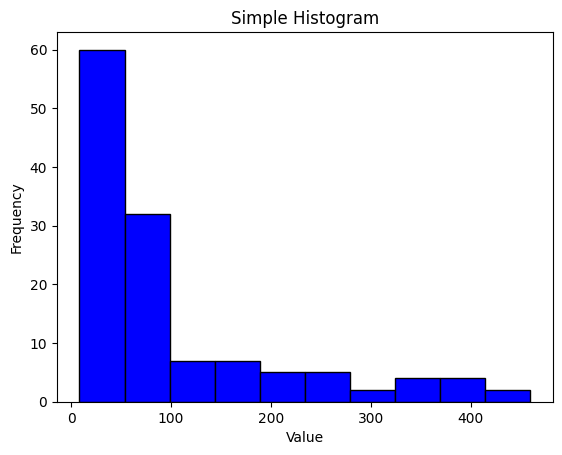

4/4 [==============================] - 0s 5ms/step
Epoch: 302/10000, D Loss: [2.9963658 0.       ], G Loss: 2.1509811631403863e-05, Val D Loss: [2.99490151 0.        ]
4/4 [==============================] - 0s 5ms/step
Epoch: 303/10000, D Loss: [3.0150347 0.       ], G Loss: 2.1188712707953528e-05, Val D Loss: [3.0124135 0.       ]
4/4 [==============================] - 0s 5ms/step
Epoch: 304/10000, D Loss: [2.9950464 0.       ], G Loss: 3.887319326167926e-05, Val D Loss: [2.99831569 0.        ]
4/4 [==============================] - 0s 4ms/step


KeyboardInterrupt: 

In [65]:
# Train the GAN with validation
import matplotlib.pyplot as plt

train_gan(generator, discriminator, gan, epochs=10000, batch_size=128, latent_dim=latent_dim, val_gen=val_gen)

In [ ]:
generator.summary()

In [ ]:
validate_generator(n_lowest = 10, n_samp = 1024*8 )

In [ ]:
validate_generator(n_lowest = 10, n_samp = 1024*8 )

In [ ]:
column_names = scaled_numeric_df.columns.tolist()
column_names

In [ ]:
val_gen

In [ ]:
tf.keras.backend.clear_session()


In [ ]:
# Example usage
validate_gan(generator, val_gen, ['elevation','landform','SRTM_mTPI'], ['agbd_m'], latent_dim, num_samples=1024, val_steps=10)
# validate_gan(generator, scaled_numeric_df, key_columns=['elevation','landform','SRTM_mTPI'], non_key_columns=['agbd_m'], latent_dim=latent_dim)
